In [1]:
import pennylane as qml
from pennylane import numpy as np

### Simple workflow:

In [19]:
qubit_register = [0, 1]
dev = qml.device("default.qubit", wires=qubit_register)


@qml.qnode(dev)
def qsvt_circ(A, phi):
    qml.qsvt(A, phi, wires=[0, 1])  # apply qsvt!
    return qml.expval(qml.PauliZ(0))


A = np.array([[0.1, 0.2], [0.3, 0.4]])
phi = np.random.rand(3)

mat = qml.matrix(qsvt_circ)(A, phi)


print("Matrix:\n", np.round(mat, 2))
print("\nGradient: ", qml.grad(qsvt_circ, argnum=1)(A, phi))  # Can also take grad w.r.t A 

Matrix:
 [[ 0.04+0.1j   0.08+0.21j  0.66+0.7j  -0.05-0.05j]
 [ 0.12+0.31j  0.16+0.41j -0.05-0.05j  0.57+0.6j ]
 [ 0.85+0.38j -0.09-0.04j -0.11-0.j   -0.33-0.01j]
 [-0.09-0.04j  0.79+0.36j -0.22-0.01j -0.44-0.02j]]

Gradient:  [[ 0.46071419+0.02079982j -0.01751437-0.0097278j ]
 [ 1.4179026 +0.04074423j -0.05290876-0.03089422j]]


### General differentiable workflow:

In [20]:
qubit_register = ["ancilla", 0, 1]
dev = qml.device("default.qubit", wires=qubit_register)

@qml.qnode(dev)
def qsvt_circ(a, phi):
    # Hadamard transform on the input register
    qml.Hadamard("ancilla")
    
    qml.ctrl(qml.qsvt, control="ancilla")(a, phi, wires=[0])  # apply controlled qsvt circuit!
    
    # Another Hadamard transform on the input register
    qml.Hadamard("ancilla")
    
    return qml.expval(qml.PauliZ("ancilla"))  # This circuit performs a "Hadamard Test" which extracts the
                                              # quantity Re(<0|U_qsvt|0>)

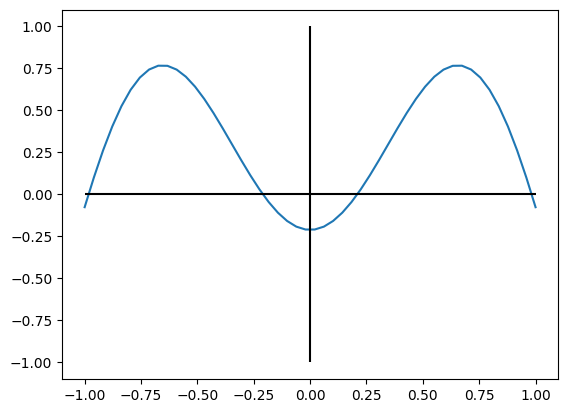

In [21]:
import matplotlib.pyplot as plt

samples_a = np.linspace(-1, 1, 50)            # Taking 50 samples of a degree 12 polynomial
phi = np.random.rand(12)

y_vals = [qsvt_circ(a, phi) for a in samples_a]  # Generate polynomial transform over the sampels

plt.plot(samples_a, y_vals)
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.show()

In [41]:
import copy

def target_poly(x):
    return 1/2 * (x**5 + x**3)

def mean_squared_error(phi):
    norm = 1 / len(samples_a)
    
    sum_square_error = 0
    for x in samples_a:
        sum_square_error += (qsvt_circ(x, phi) - target_poly(x))**2
        
    return norm * sum_square_error


# Initialize parameters: 
phi = np.random.rand(5)
phi_initial = copy.copy(phi)

# Optimization:
opt = qml.AdagradOptimizer(0.3)
for epoch in range(30):  
    phi, cost = opt.step_and_cost(mean_squared_error, phi)
    if (epoch + 1) % 5 == 0:
        print(f"iter: {epoch+1}, cost: {cost}")

print("Completed Optimization!")

iter: 5, cost: 0.012876167801861817
iter: 10, cost: 0.011917662047667792
iter: 15, cost: 0.01086683446897683
iter: 20, cost: 0.009716698130135256
iter: 25, cost: 0.008518076791807945
iter: 30, cost: 0.007344513783302862
Completed Optimization!


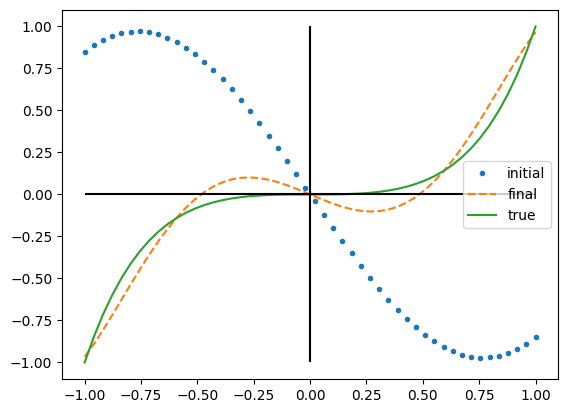

In [42]:
y_vals_init = [qsvt_circ(a, phi_initial) for a in samples_a]  # Generate polynomial transform over the samples
y_vals_final = [qsvt_circ(a, phi) for a in samples_a]
true_y_vals = [target_poly(a) for a in samples_a]

plt.plot(samples_a, y_vals_init, ".", label="initial")
plt.plot(samples_a, y_vals_final, "--", label="final")
plt.plot(samples_a, true_y_vals, label="true")
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.legend()
plt.show()

### Angle Solver

In [64]:
from numpy.polynomial.polynomial import Polynomial as Poly

def qsvt_phases(poly_coeffs, method="default", accuracy=1e-2, max_iteration=1000):
    """Optimize qsvt phases for the given polynomial"""
    degree = len(poly_coeffs) - 1
    phi_init = get_init_phi(degree)
    
    # get samples
    num_samples = max(10, degree + 1)
    samples = get_samples(num_samples, method=method)
    
    
    # split even and odd coeffs
    even_coeffs = [coeff if i%2==0 else 0.0 for i, coeff in enumerate(poly_coeffs)]
    odd_coeffs = [coeff if (i+1)%2==0 else 0.0 for i, coeff in enumerate(poly_coeffs)]
    

    # validation + execution: 
    zero_even = np.allclose(even_coeffs, np.zeros(degree + 1), atol=1e-8)
    zero_odd = np.allclose(odd_coeffs, np.zeros(degree + 1), atol=1e-8)
    
    
    if zero_even and zero_odd:
        raise ValueError("Recieved 0 polynomial to approximate")
    
    elif zero_even:
        optimized_phi_odd = run_optimizer(phi_init, Poly(odd_coeffs), accuracy=1e-3, max_iter=200, samples=samples, verbose=False)
        return (optimized_phi_odd, None)
    
    elif zero_odd:
        optimized_phi_even = run_optimizer(phi_init, Poly(even_coeffs), accuracy=1e-3, max_iter=200, samples=samples, verbose=False)
        return (None, optimized_phi_even)
    
    optimized_phi_odd = run_optimizer(phi_init, Poly(odd_coeffs), accuracy=1e-3, max_iter=200, samples=samples, verbose=False)
    optimized_phi_even = run_optimizer(phi_init, Poly(even_coeffs), accuracy=1e-3, max_iter=200, samples=samples, verbose=False)
    
    return optimized_phi_odd, optimized_phi_even


def get_samples(num_s, method="default"):
    if method == "l-bfgs":
        d_tilde = np.ceil((num_s+1)/2)
        return np.cos([np.pi*(2*k - 1)/(4*d_tilde) for k in range(1, d_tilde+1)])
    
    return np.linspace(-1, 1, num_s)  # uniformly sample the domain

def get_init_phi(dim):
    zero_params = np.zeros(dim)
    zero_params[0] = np.pi/4
    zero_params[-1] = np.pi/4
    return zero_params


def run_optimizer(init_phi, target_poly, accuracy, max_iter, samples, verbose=False):
    """Initialize and execute optimization, return results."""
    
    # initialize hyper parameters: 
    phi = copy.copy(init_phi)
    step_size = 0.5
    opt = qml.AdagradOptimizer(step_size)

    
    # loss function:
    def _mean_squared_error(phi):
        norm = 1 / len(samples)
        sum_square_error = 0
    
        for x in samples:
            sum_square_error += (qsvt_circ(x, phi) - target_poly(x))**2
        
        return norm * sum_square_error
    
    i = 0
    cost = accuracy
    while i < max_iter and cost >= accuracy: 
        phi, cost = opt.step_and_cost(_mean_squared_error, phi)
        
        if verbose and i % 10 == 0:
            print(f"iter: {i}, cost: {cost}")
        i += 1
    
    return (i, cost, phi)

In [67]:
print(qsvt_phases([0, 1/2, 0, 1/2]))

iter: 0, cost: 0.31183028784004235
iter: 10, cost: 0.003369407841599697
iter: 20, cost: 0.0014027809940371162
((27, tensor(0.00095766, requires_grad=True), tensor([ 0.33962265, -0.63059545,  0.59501371], requires_grad=True)), None)


### Benchmarking